In [2]:
#Setting up the environment. Reinstalling numpy to fix module attribution errors
!pip install tensorflow>=1.15 numpy==1.23.5 pandas>=0.24 absl-py
!pip install scikit-learn==1.0.2
!pip uninstall -y numpy
!pip install numpy==1.23.5

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.25.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.87 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jax 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
xarray 2024.10.0 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 38.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      

In [1]:
!git clone https://github.com/agarwl/google-research.git

Cloning into 'google-research'...
remote: Enumerating objects: 19326, done.
remote: Total 19326 (delta 0), reused 0 (delta 0), pack-reused 19326 (from 1)
Receiving objects: 100% (19326/19326), 239.78 MiB | 15.26 MiB/s, done.
Resolving deltas: 100% (9279/9279), done.
Updating files: 100% (7065/7065), done.


In [2]:
%cd google-research/neural_additive_models

/content/google-research/neural_additive_models


In [3]:
!sed -i 's/sklearn/scikit-learn/g' setup.py

In [4]:
!pip install -e .

Obtaining file:///content/google-research/neural_additive_models
  Preparing metadata (setup.py) ... done
  Running setup.py develop for neural_additive_models


In [5]:
#Upload either the housing data or archive (Cement-tensile strenght data)
from google.colab import files
files.upload()

Saving archive.zip to archive.zip


{'archive.zip': b'PK\x03\x04-\x00\x00\x00\x08\x00L\x0b5O\xf4?\xf3\x97\xff\xff\xff\xff\xff\xff\xff\xff\x11\x00\x14\x00concrete_data.csv\x01\x00\x10\x00\x82\xe6\x00\x00\x00\x00\x00\x00\xa7+\x00\x00\x00\x00\x00\x00\xa5}[\x8ed9\xae\xe4\xff\x00\xb3\x87\\@\xc1q$\x1d\xbdV\xd3\xa8)d\xd7m\xa0o\xdfFU\xdd\x19\xcc\xac~D3\xd3\x91<\xdc#\xd2\xe9\xf9\x93\x8f\x087\x97DQ&\x92\xa2\xa8\xdf\xbe\xff\xe7\xf7\x7f\xfd\xf5\xcb\xff\xfa\xe7\xaf\x7f\xfe\xf5\xb7\xbf\xff\xf7\x1f\xff\xfa\xf5\xb7\xef\x7f\xfb\xf3\x9f\xbf\xfe\xfe\xcb\xdf\xff\xf9\x7f\xff\xf6\xeb\x9f\xff\xf1\xcb\xff\xf9\xf5\xaf\xef\x7f\xfc\xf2\xe7\x7f\xff\xfb\xfb\x1f\xff\xb6O\xfd\xe3\xb7\x7f\xfc\xbf\xf1\x83\xdf\xfe\xeb\xd7?\xfe\xfc\xfe\xb7_\x7f\xff\xfd\x8f\xef\xbf\x8f\x8f\xfc\xf2\xf7\x7f\xfck\xfb\xef\xb7_~\xfd\xfd\xfb\xf8\xd0\xbf~\xfb\xe3\xfb_\xdf\xff\xf6\xdb\x7f\xfd\xe7\xbf\xff\xf8\xfe\xe7\x9f\xff\xf8\xdf\xe3\xdb\xff\xfa\xe3\xfb\xbf~\xff\xeb?\xfe\xe7\xff\xc8\xe7q;\xbe\xfd\xb2\xfe\x08%\xda_\xf1\x96\xc7\xbf\x0f\xfe\xb6\xd4\x82\x9f\xb5o\xbf\xd4~\xeb\xfd\xdb

In [6]:
#Run only when using housing data used for the NAM paper
!unzip housing2.zip

unzip:  cannot find or open housing2.zip, housing2.zip.zip or housing2.zip.ZIP.


In [8]:
!unzip /content/google-research/neural_additive_models/archive.zip -d /content/google-research/neural_additive_models/data

Archive:  /content/google-research/neural_additive_models/archive.zip
  inflating: /content/google-research/neural_additive_models/data/concrete_data.csv  


In [9]:
#@title Imports

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import importlib

import data_utils
import models as nam_models
import graph_builder
import os.path as osp
import numpy as np
import nam_train

import matplotlib.pyplot as plt

In [36]:
import pandas as pd

# Load dataset
data_set = pd.read_csv('/content/google-research/neural_additive_models/data/concrete_data.csv')

In [37]:
# Separate features and target
X = data_set.iloc[:, :8]  # Features
y = data_set.iloc[:, 8]   # Target

In [38]:
data_x, column_names = data_utils.transform_data(X)
data_x = data_x.astype('float32')
data_y = y.astype('float32')
data_y = np.array(data_y)
ins_data = (data_x, data_y, column_names)
is_regression = True

In [40]:
(x_train_all, y_train_all), test_dataset = data_utils.get_train_test_fold(
      data_x, data_y, fold_num=1, num_folds=5, stratified=not is_regression)
data_gen = data_utils.split_training_dataset(
      x_train_all, y_train_all,
      n_splits=5, stratified=not is_regression)
(x_train, y_train), _ = next(data_gen)

In [41]:
# Modifying the models.py file to set the model attribute to include layers after being built
from google.colab import files
files.view('models.py')

<IPython.core.display.Javascript object>

In [17]:
#Reload the import to reflect the changes
importlib.reload(nam_models)

<module 'models' from '/content/google-research/neural_additive_models/models.py'>

In [44]:
#@title Create NAM model

tf.compat.v1.reset_default_graph()
nn_model = graph_builder.create_nam_model(
    x_train=x_train,
    dropout=0.0,
    num_basis_functions=32,
    activation='relu',
    trainable=True,
    shallow=False,
    name_scope='model_0')

_ = nn_model(x_train[:1])
nn_model.summary()

Model: "nam_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_nn_24 (FeatureNN)            │ ?                           │           4,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_25 (FeatureNN)            │ ?                           │           4,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_26 (FeatureNN)            │ ?                           │           4,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_27 (FeatureNN)            │ ?                           │           4,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_28 (FeatureNN)            │ ?                           │           4,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_29 (FeatureNN)            │ ?                           │           4,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_30 (FeatureNN)            │ ?                           │           4,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_31 (FeatureNN)            │ ?                           │           4,024 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,041 (132.97 KB)

 Trainable params: 34,041 (132.97 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
#Compile the model to be trained
nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Mean squared error (or another loss depending on your task)
    metrics=['mae']
)

In [46]:
# Train the NAM Model with interminient checking for accuracy
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Or 'val_accuracy' depending on your metric
    patience=5,  # Number of epochs to wait for improvement
    restore_best_weights=True
)

history = nn_model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 1551.9653 - mae: 35.4936
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1111.9568 - mae: 28.8813
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 644.8366 - mae: 20.0662
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 305.8288 - mae: 13.8166
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 265.6307 - mae: 13.0297
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 288.7920 - mae: 13.5457
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 231.2100 - mae: 12.1741
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 215.9129 - mae: 11.8291
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 167.5989 - mae: 10.5113
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 162.5378 - mae: 10.1120
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 148.0658 - mae: 9.9070
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 132.1987 - mae: 9.2272
Epoch 1

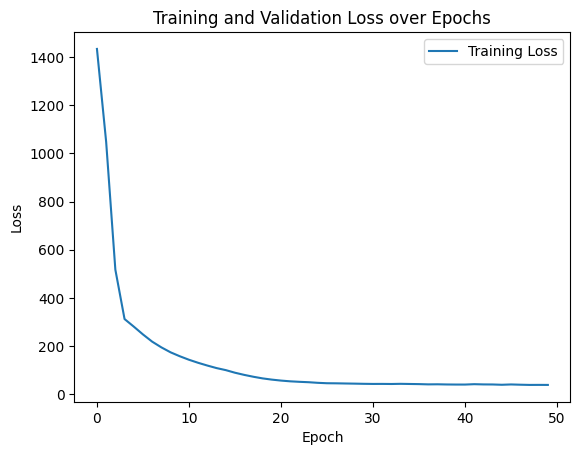

In [47]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [33]:
# Initialize CNN network via Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv1D(32, kernel_size=2, activation='relu', input_shape=(8, 1)),
    Dropout(0.2),
    Conv1D(64, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)  # Single output for regression
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 7, 32)               │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 6, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,961 (113.13 KB)

 Trainable params: 28,961 (113.13 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
x_train = x_train.reshape((721, 8, 1))


In [29]:
#Train the CNN Model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1444.6946
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 996.6008 
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 349.0425
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 340.8108
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 331.4262
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 288.3838
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 265.9223
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 253.0593
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 236.4930
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 216.7267
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 203.2913
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 188.0355
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 176.0622
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 172.6026
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - lo

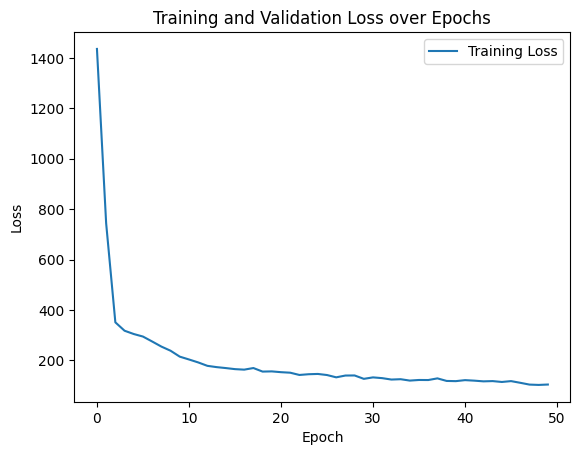

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [31]:
 !pip freeze > requirements.txt

In [32]:
files.view('requirements.txt')

<IPython.core.display.Javascript object>